Data Loaded and Cleaned:
        Date       Product  Quantity  Price  Total Date_original    Month
0 2023-01-01     Chocolate         5   10.0   50.0    2023-01-01  2023-01
1 2023-01-02      Biscuits         7   20.0  140.0    2023-01-02  2023-01
2 2023-01-03        Sweets         9   15.0  135.0    2023-01-03  2023-01
3 2023-01-04         Water         3    7.5   22.5    2023-01-04  2023-01
4 2023-01-05  Orange Juice         8   12.5  100.0    2023-01-05  2023-01


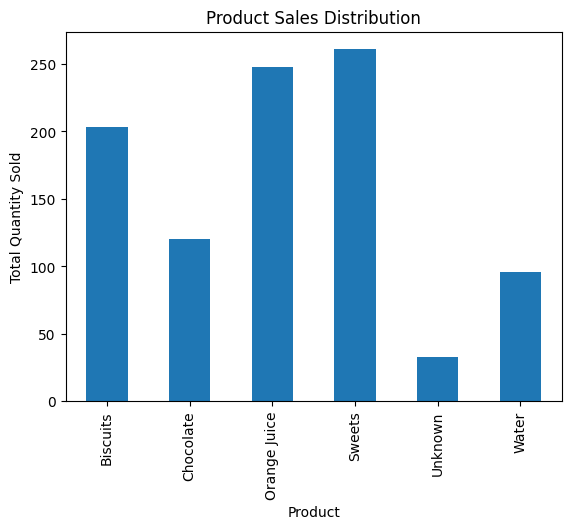

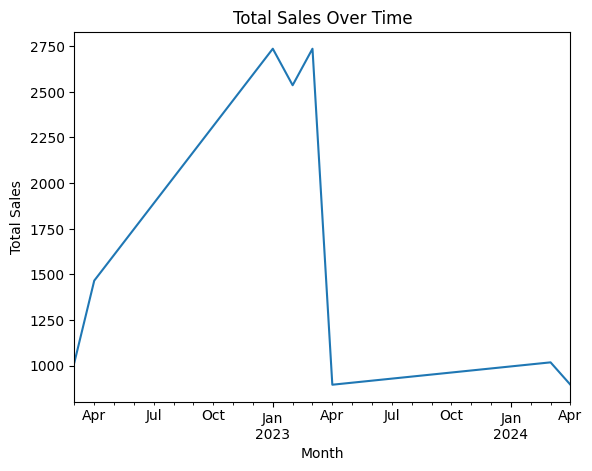

Data inserted into SalesDB.
Total Sales in 2023: 17800.0
Product Sales Summary in 2023:
Product: Sweets, Total Quantity Sold: 360
Product: Orange Juice, Total Quantity Sold: 304
Product: Biscuits, Total Quantity Sold: 280
Product: Chocolate, Total Quantity Sold: 190
Product: Water, Total Quantity Sold: 120
Product: Unknown, Total Quantity Sold: 26
-----------------------------------------------------------------


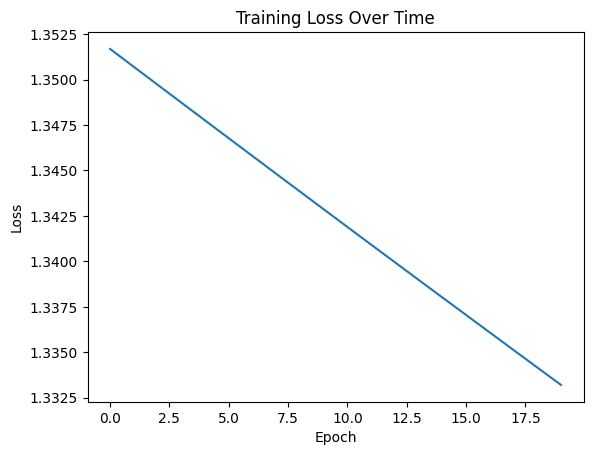

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import torch
import torch.nn as nn
import torch.optim as optim

# --- Part 1: Python Basics and Data Manipulation ---

# Task 1a: Data Loading and Preprocessing
# Load the data and parse dates
df = pd.read_csv('sales_data.csv', parse_dates=['Date'], dayfirst=True)

# Data Cleaning
# Fill missing values
df.fillna({
    'Product': 'Unknown',
    'Quantity': 0,
    'Price': 0.0,
    'Total': 0.0
}, inplace=True)

# Keep the original datetime column for operations
df['Date_original'] = df['Date']

# Convert Date to Period (Month) using the original datetime column
df['Month'] = df['Date_original'].dt.to_period('M')

# Ensure Total column is correct
df['Total'] = df['Quantity'] * df['Price']

print("Data Loaded and Cleaned:")
print(df.head())

# Task 1b: Data Visualization
# Product Sales Distribution
product_sales = df.groupby('Product')['Quantity'].sum()
product_sales.plot(kind='bar', title='Product Sales Distribution', ylabel='Total Quantity Sold', xlabel='Product')
plt.show()

# Sales Over Time (2023)
# Group by Month and calculate total sales per month
monthly_sales = df.groupby('Month')['Total'].sum()

# Plot the results
monthly_sales.plot(kind='line', title='Total Sales Over Time', ylabel='Total Sales', xlabel='Month')
plt.show()

# Convert Date to string for database insertion
df['Date'] = df['Date_original'].dt.strftime('%Y-%m-%d')

# --- Part 2: Python Database Management ---

# Task 2a: Database Creation and Data Insertion
# Create the database
conn = sqlite3.connect('SalesDB.db')
cursor = conn.cursor()

# Create the Sales table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS Sales (
        Date TEXT,
        Product TEXT,
        Quantity INTEGER,
        Price REAL,
        Total REAL
    )
''')

# Insert data into the Sales table
for _, row in df.iterrows():
    cursor.execute('''
        INSERT OR IGNORE INTO Sales (Date, Product, Quantity, Price, Total)
        VALUES (?, ?, ?, ?, ?)
    ''', (row['Date'], row['Product'], row['Quantity'], row['Price'], row['Total']))

conn.commit()
print("Data inserted into SalesDB.")

# Task 2b: Querying the Database
# Total Sales Calculation
cursor.execute('''
    SELECT SUM(Total) FROM Sales WHERE strftime('%Y', Date) = '2023'
''')
total_sales = cursor.fetchone()[0]
print(f"Total Sales in 2023: {total_sales}")

# Product Sales Summary
cursor.execute('''
    SELECT Product, SUM(Quantity) FROM Sales
    WHERE strftime('%Y', Date) = '2023'
    GROUP BY Product
    ORDER BY SUM(Quantity) DESC
''')
product_summary = cursor.fetchall()
print("Product Sales Summary in 2023:")
for product, total_quantity in product_summary:
    print(f"Product: {product}, Total Quantity Sold: {total_quantity}")

conn.close()

print("-----------------------------------------------------------------")

# --- Part 3: Basic Neural Network Implementation ---

# Task 3a: Neural Network Construction
# Define the neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(10, 5)  # Input layer: 10 features -> 5 neurons
        self.fc2 = nn.Linear(5, 3)   # Hidden layer: 5 neurons -> 3 neurons
        self.fc3 = nn.Linear(3, 1)   # Output layer: 3 neurons -> 1 neuron

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# Instantiate the model
model = SimpleNN()
criterion = nn.MSELoss()  # Mean Squared Error loss function
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Stochastic Gradient Descent optimizer

# Generate synthetic data
data = torch.randn(100, 10)  # 100 samples, 10 features each
target = torch.randn(100, 1)  # 100 target values

# Training the network
losses = []
for epoch in range(20):  # Train for 20 epochs
    optimizer.zero_grad()  # Zero the gradients
    output = model(data)  # Forward pass
    loss = criterion(output, target)  # Compute the loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights
    losses.append(loss.item())  # Record the loss

# Plotting the training loss over time
plt.plot(losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()